# Question 4

## Imports

In [3]:
import sklearn
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt

## Part (a): Load the Dataset

In [4]:
def load_data():
    data = sklearn.datasets.load_iris()

    # Extract all four features as input (X)
    X: np.ndarray = data.data

    # Extract the class labels (y) - 0, 1, 2
    y: np.ndarray = data.target
    # one hot encode the target labels
    y = np.eye(3)[y]

    assert X.shape[0] == y.shape[0]
    return (X, y, data.target_names)

## Part (b): Preprocess the Data

In [8]:
def preprocess(X: np.ndarray, y: np.ndarray, split_percent=0.6, normalisation_method="normalise", _print=False):
    if normalisation_method not in ["normalise", "standardise", "unchanged"]:
        raise ValueError("Invalid normalisation method")

    assert X.shape[0] == y.shape[0]

    if normalisation_method == "normalise":
        min_x = np.min(X, axis=0)
        max_x = np.max(X, axis=0)
        X = (X - min_x) / (max_x - min_x)

    elif normalisation_method == "standardise":
        mean_x = np.mean(X, axis=0)
        std_x = np.std(X, axis=0)
        X = (X - mean_x) / std_x

    # Add a bias term to the input
    X = np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)

    # Shuffle the data
    indices = np.random.permutation(X.shape[0])
    X = X[indices]
    y = y[indices]

    # Split the data into train and test
    split_size = int(split_percent * X.shape[0])

    x_train, x_test = X[:split_size], X[split_size:]
    y_train, y_test = y[:split_size], y[split_size:]

    if _print:
        print(f"Train data shape: {x_train.shape}, {y_train.shape}")
        print(f"Test data shape: {x_test.shape}, {y_test.shape}")

        # Print num samples per class in train and test
        print("\nTrain data class distribution")
        pprint({i: int(np.sum(y_train[:, i])) for i in range(y_train.shape[1])})
        print("\nTest data class distribution")
        pprint({i: int(np.sum(y_test[:, i])) for i in range(y_test.shape[1])})

        print("\n")

    return (x_train, y_train), (x_test, y_test)

## Part (c): Implement Softmax Function

In [6]:
def softmax(values: np.ndarray):
    exp_vals = np.exp(values)
    softmax_vals = exp_vals / np.sum(exp_vals, axis=1, keepdims=True)
    return softmax_vals

## Part (d): Implement Multiclass Logistic Regression

In [7]:
def cross_entropy_loss(X: np.ndarray, theta: np.ndarray, y: np.ndarray):
    m = X.shape[0]
    y_pred = softmax(X @ theta)
    loss = np.sum(y * np.log(y_pred))
    loss = -1 / m * loss
    return loss

def gradient_cross_entropy(X: np.ndarray, theta: np.ndarray, y: np.ndarray):
    m = X.shape[0]
    y_pred = softmax(X @ theta)
    grad = 1 / m * X.T @ (y_pred - y)
    return grad

In [18]:
def get_accuracy(y_pred, y_true):
    y_pred = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_true, axis=1)
    accuracy = np.mean(y_pred == y_true)
    return accuracy

def train(normalisation_method, gd_method, epochs=1, lr=0.00001, convergence_threshold=1e-6, _print=False):
    if gd_method not in ["GD", "SGD"]:
        raise ValueError("Invalid GD method")

    X, y, target_names = load_data()
    (x_train, y_train), (x_test, y_test) = preprocess(X, y, normalisation_method=normalisation_method)

    # theta is a len(x_train[0]) * len(y_train[0]) matrix
    theta = np.zeros((x_train.shape[1], y_train.shape[1]))
    losses = []
    accuracies = []

    losses.append(cross_entropy_loss(x_train, theta, y_train))
    accuracies.append(get_accuracy(softmax(x_test @ theta), y_test))

    for iter in range(1, epochs + 1):
        if gd_method == "GD":
            # Compute grad for the entire dataset
            grad = gradient_cross_entropy(x_train, theta, y_train)

        elif gd_method == "SGD":
            # Compute grad for a single example
            idx = np.random.randint(0, x_train.shape[0])
            grad = gradient_cross_entropy(x_train[idx:idx+1], theta, y_train[idx:idx+1])

        theta = theta - lr * grad
        loss = cross_entropy_loss(x_train, theta, y_train)
        losses.append(loss)

        accuracy = get_accuracy(softmax(x_test @ theta), y_test)
        accuracies.append(accuracy)

        loss_diff = losses[-2] - losses[-1]
        if gd_method == "GD" and abs(loss_diff) < convergence_threshold:
            if _print:
                print(f"Converged at iteration {iter}")
            break

        last_losses = losses[-10:]
        # max(loss - mean) < threshold
        if gd_method == "SGD" and max(last_losses) - np.mean(last_losses) < convergence_threshold:
            if _print:
                print(f"Converged at iteration {iter}")
            break

    # Compute the accuracy on the test set
    y_pred = softmax(x_test @ theta)
    y_test = np.argmax(y_test, axis=1)
    if _print:
        print(f"Accuracy: {accuracies[-1]}\n")
        print(sklearn.metrics.classification_report(y_test, y_pred, target_names=target_names))

    return losses, accuracies

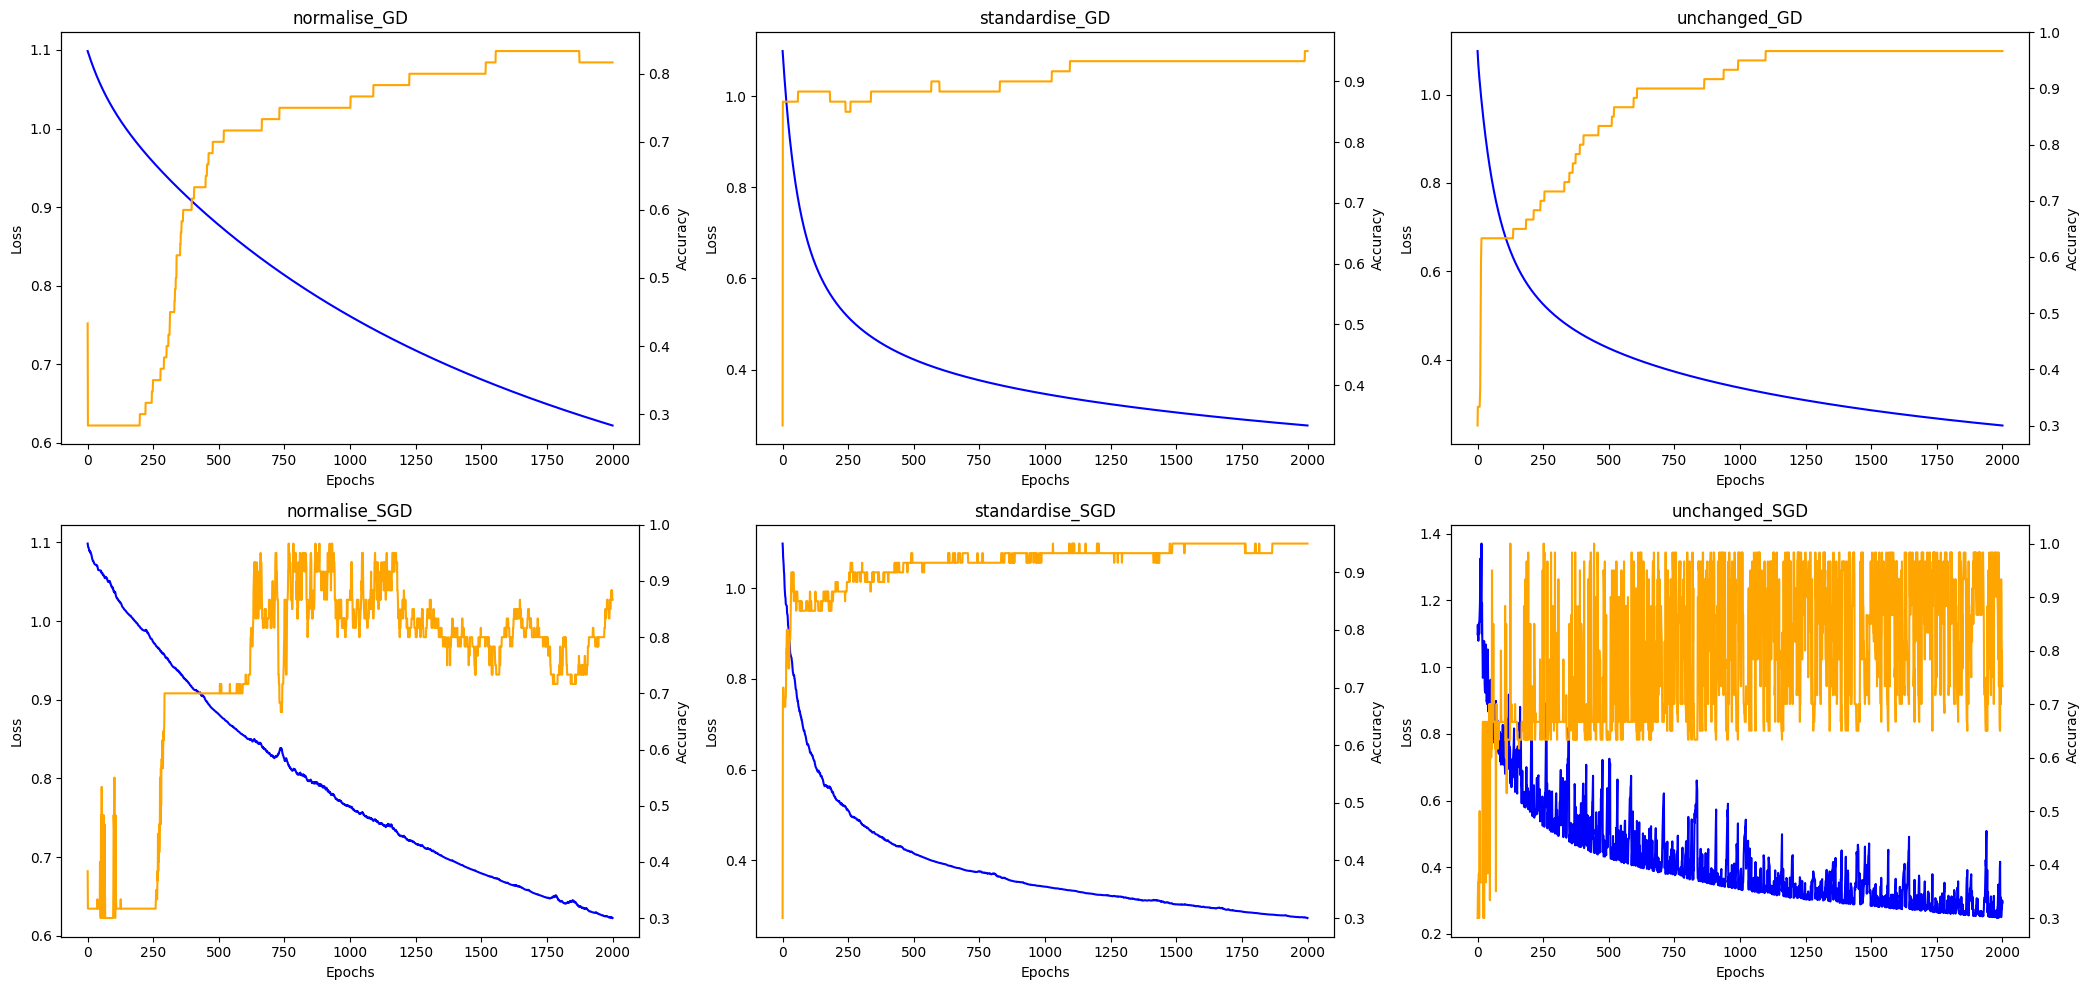

In [35]:
configs = {
    "normalise_GD": {
        "normalisation_method": "normalise",
        "gd_method": "GD",
    },
    "standardise_GD": {
        "normalisation_method": "standardise",
        "gd_method": "GD",
    },
    "unchanged_GD": {
        "normalisation_method": "unchanged",
        "gd_method": "GD",
    },
    "normalise_SGD": {
        "normalisation_method": "normalise",
        "gd_method": "SGD",
    },
    "standardise_SGD": {
        "normalisation_method": "standardise",
        "gd_method": "SGD",
    },
    "unchanged_SGD": {
        "normalisation_method": "unchanged",
        "gd_method": "SGD",
    },
}

fig, axs = plt.subplots(2, 3, figsize=(21, 10))
axs = axs.flatten()  # Flatten the 2D array for easier iteration

for ax, (name, cfg) in zip(axs, configs.items()):
    losses, accuracies = train(**cfg, epochs=2000, lr=0.01)

    (line1,) = ax.plot(losses, label="Loss", color="blue")
    ax.set_ylabel("Loss")
    ax.tick_params(axis="y")

    ax2 = ax.twinx()
    (line2,) = ax2.plot(accuracies, label="Accuracy", color="orange")
    ax2.set_ylabel("Accuracy")
    ax2.tick_params(axis="y")

    ax.set_title(name)
    ax.set_xlabel("Epochs")

    # Combine legends from both axes
    lines = [line1, line2]
    labels = [l.get_label() for l in lines]

plt.tight_layout()
plt.show()